In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal
from utils import generate_and_avaliate_model
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,gvtec3,gvtec3_dt,s4
2013-12-01 02:10:00,38.901869,-1.406371,0.090805,-3.012794,-0.302865,-0.138129,-2.709478,-0.748023,-0.046265,0.116034
2013-12-01 02:20:00,37.676039,-1.201542,0.204829,-3.176458,-0.149123,-1.840996,-1.712064,-0.797389,-0.046810,0.112015
2013-12-01 02:30:00,36.751092,-0.957067,0.244475,-3.090844,0.030793,-2.211419,-0.669840,-0.815543,-0.040540,0.111552
2013-12-01 02:40:00,36.059834,-0.762969,0.194098,-2.880283,0.127728,-1.957485,-0.038873,-0.858718,-0.060494,0.108269
2013-12-01 02:50:00,35.416633,-0.653073,0.109896,-2.733366,0.097938,-1.737745,0.141762,-0.969081,-0.102394,0.106616


### (1) Estimação de s4 com vtec

Error for the time series sample:
acc              0.911164
f1               0.107178
far              0.820139
fn              82.200000
fp              30.800000
kappa            0.058664
me               0.424665
mse              0.003518
pod              0.076404
precission       0.179861
re              16.770462
recall           0.076404
tn            1152.200000
tp               6.800000
tse              2.115240
dtype: float64


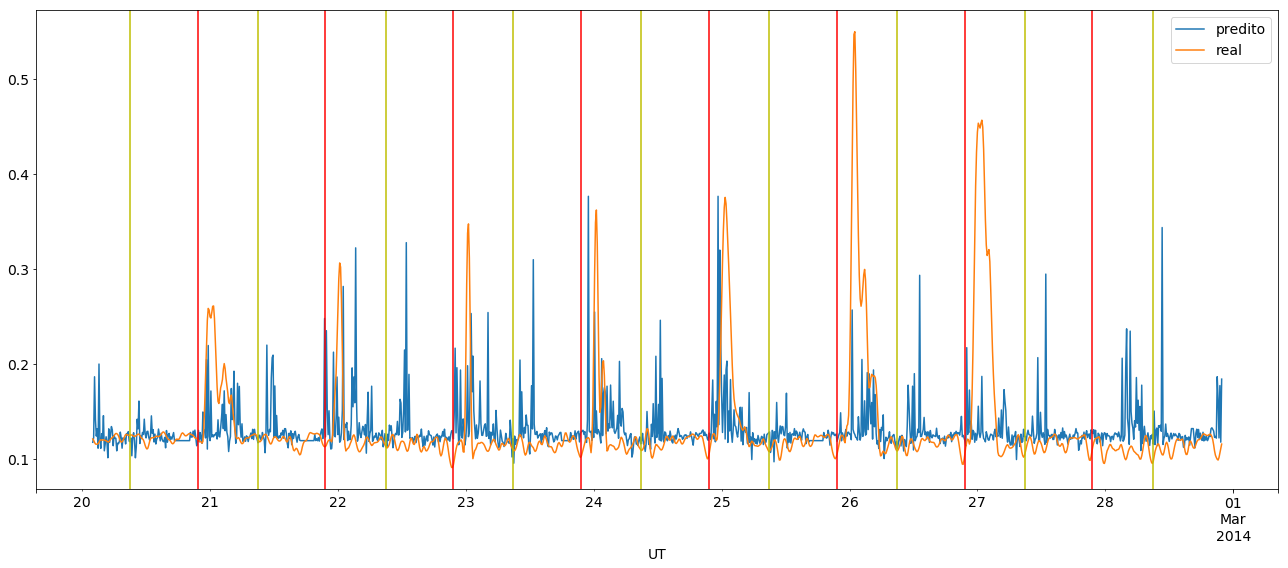

In [4]:
instances_set = ['vtec']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')

### (2) Estimação de s4 com vtec, vtec_dt e vtec_dt2

Error for the time series sample:
acc              0.924371
f1               0.432799
far              0.545064
fn              52.000000
fp              44.200000
kappa            0.037626
me               0.373347
mse              0.002654
pod              0.415730
precission       0.454936
re              17.461268
recall           0.415730
tn            1138.800000
tp              37.000000
tse              1.836795
dtype: float64


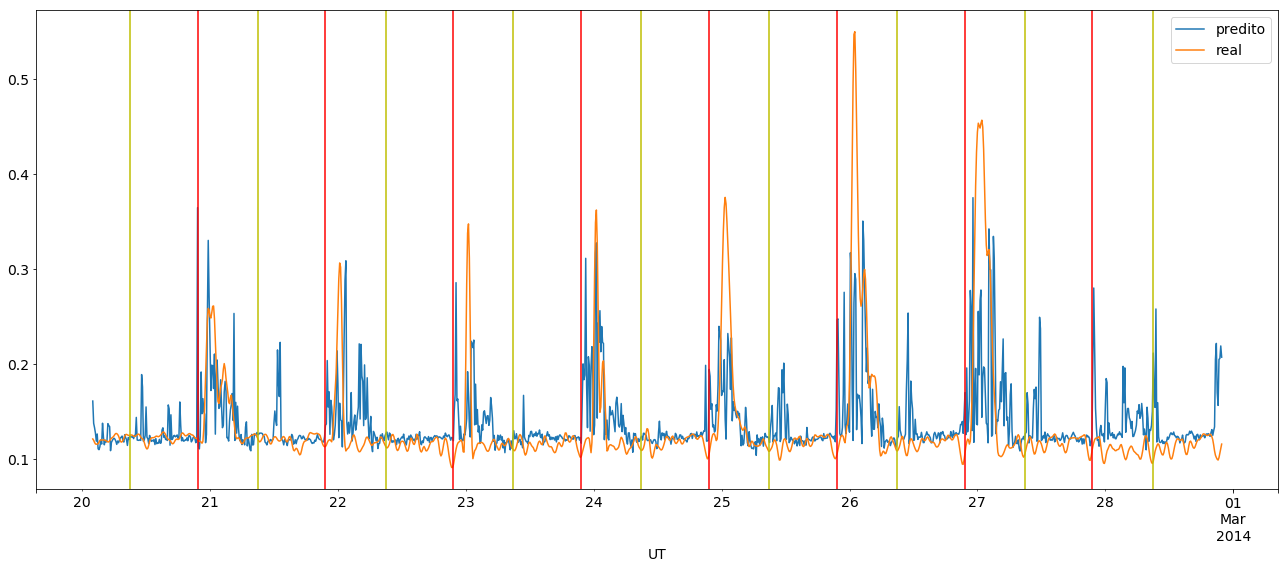

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')

### (3) Estimação de S4 com vtec, gvtec1 e gvtec2

Error for the time series sample:
acc              0.921619
f1               0.207499
far              0.644295
fn              75.900000
fp              23.800000
kappa            0.054575
me               0.385594
mse              0.002814
pod              0.147191
precission       0.355705
re              15.717000
recall           0.147191
tn            1159.200000
tp              13.100000
tse              1.891634
dtype: float64


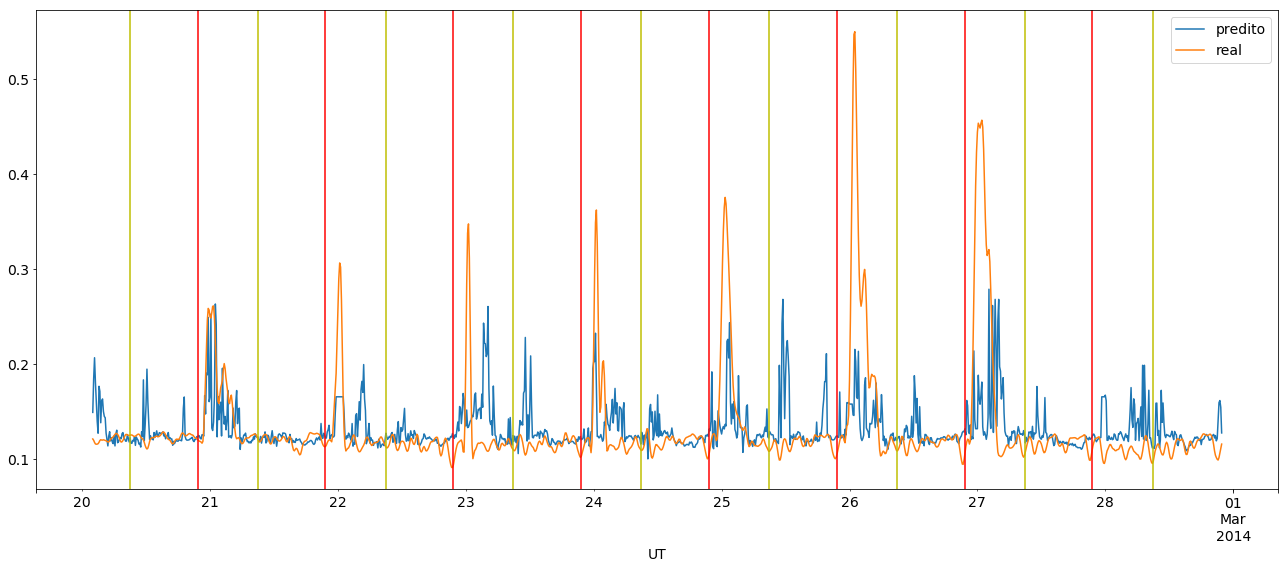

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
dict_error = generate_and_avaliate_model(df=df,
                                         instances_set=instances_set,
                                         target='s4')